# Equation of State
This uses the [equation of state](https://github.com/dionhaefner/pyhpc-benchmarks/blob/master/benchmarks/equation_of_state/eos_jax.py) from the [`pyhpc`](https://github.com/dionhaefner/pyhpc-benchmarks/) benchmark.

In [10]:
import os, copy
#ncpu=1
#os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={ncpu}"
#os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false " "intra_op_parallelism_threads=1")
#os.environ['JAX_PLATFORMS'] = "cpu"

import numpy as np
import jax
import sys
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random

# This must be enabled when `make_jaxpr` is called, because otherwhise we get problems.
jax.config.update("jax_enable_x64", True)


import timeit
from datetime import datetime
from pickle import dump


import pyhpc
from pyhpc.equation_of_state import get_callable, generate_inputs
from pyhpc.equation_of_state.eos_jax import gsw_dHdT as CALL
from pyhpc.equation_of_state.eos_numpy import gsw_dHdT as gsw_dHdT_NP

import dace


#### Parameter of Benchmarking

In [2]:
repeat, number = 30, 10 # 3000, 50

#### The `JAX->SDFG` Translator

In [3]:
from JaxprToSDFG import  JaxprToSDFG
t = JaxprToSDFG()

###### Options for Compilation

In [4]:
_build_type = "Release"
# removing  -ffast-math from DaCe default compiler args in order to support isfinite/isinf/isnan built-ins
_cpu_args = dace.config.Config.get("compiler", "cpu", "args").replace('-ffast-math', '') + ' -fopenmp' + ' -faligned-new'

### Bench Loop

In [5]:
xSizes = np.array([5 * i  for i in range(1, 10)])
ySizes = xSizes.copy()
gSizes = np.array([50 * i  for i in range(1, 4)])

resTime_sdfg = []
resTime_pf   = []
resTime_jax  = []

for gSize in gSizes:
    print(f"Start with size {gSize}")
    # Generate the input that we use
    INP = generate_inputs(gSize)

    # Generate the SDFG that is based on the Python frontend
    CallPFSDFG = dace.program(auto_optimize=True, recreate_sdfg=True)(gsw_dHdT_NP)

    # Generate the SDFG we will use to call
    with jax.disable_jit(disable=True):
        JaxprCall = jax.make_jaxpr(CALL)(*INP)
        CallSDFG = t(JaxprCall, simplify=True, auto_opt=5, ret_by_arg=True)
    #
    with dace.config.temporary_config():
        dace.config.Config.set("compiler", "build_type", value=_build_type)
        dace.config.Config.set("compiler", "cpu", "args", value=_cpu_args)
        CallDaCe = CallSDFG.compile()
        CallPF   = CallPFSDFG.compile(*INP, simplify=True)
    #

    # Now generate the Jax Call
    CallJax = jax.jit(CALL)

    # Now call JAX and SDFG once
    _out = np.zeros_like(INP[0])
    _ = CallJax(*INP).block_until_ready()
    _ = CallDaCe(*INP, _out)
    _ = CallDaCe._fast_call(*CallDaCe._lastargs)
    _ = CallPF(*INP)
    _ = CallPF._fast_call(*CallPF._lastargs)

    # Run JAX
    t_ = timeit.Timer(lambda: CallJax(*INP).block_until_ready() )
    r = np.array(t_.repeat(repeat, number))
    resTime_jax.append(r)

    
    # Run Python Frontend
    t_ = timeit.Timer(lambda: CallPF._fast_call(*CallPF._lastargs))
    r = np.array(t_.repeat(repeat, number))
    resTime_pf.append(r)

    
    # Run SDFG
    t_ = timeit.Timer(lambda: CallDaCe._fast_call(*CallDaCe._lastargs))
    r = np.array(t_.repeat(repeat, number))
    resTime_sdfg.append(r)
#

Now = datetime.now()
with open(f'EqOfState__{Now.year}-{Now.month}-{Now.day}_{Now.hour}-{Now.minute}-{Now.second}.pickle', '+bw') as F:
    dump((KDimNs, resTime_pf, resTime_jax, resTime_sdfg), F)
#

Start with size 50
Start with size 100on.Elimination.


/home/quint_essent/git/1_CSCS/jax_demo/dace/sdfg/sdfg.py:2191: UserWarning: SDFG "pyhpc_equation_of_state_eos_numpy_gsw_dHdT" is already loaded by another object, recompiling under a different name.
  warnings.warn('SDFG "%s" is already loaded by another object, '


Start with size 150


In [6]:
resTime_sdfg_min = np.array([r.min()  for r in resTime_sdfg])
resTime_jax_min = np.array([r.min()  for r in resTime_jax])
resTime_pf_min = np.array([r.min()  for r in resTime_pf])

resTime_sdfg_mean = np.array([r.mean()  for r in resTime_sdfg])
resTime_jax_mean = np.array([r.mean()  for r in resTime_jax])
resTime_pf_mean = np.array([r.mean()  for r in resTime_pf])

resTime_sdfg_std = np.array([r.std()  for r in resTime_sdfg])
resTime_jax_std = np.array([r.std()  for r in resTime_jax])
resTime_pf_std = np.array([r.std()  for r in resTime_pf])

In [7]:
import matplotlib as mpl
from matplotlib import pyplot as plt

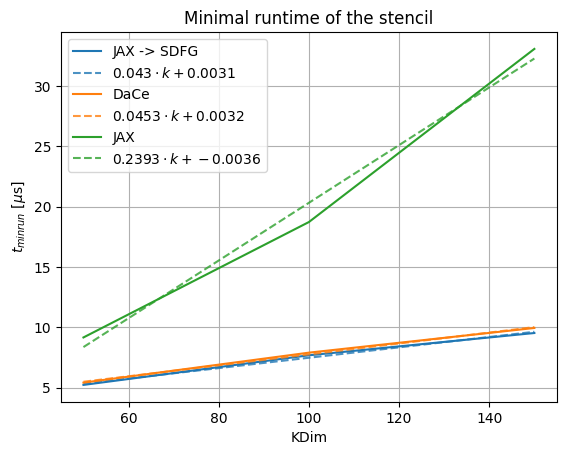

In [8]:
X = np.vstack([gSizes, np.ones_like(gSizes)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'DaCe':         resTime_pf_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(gSizes, Time * 1000000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = np.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * np.array(gSizes) + b
    plt.plot(
        gSizes, Times_ * 1000000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e6*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )
#


plt.legend()
plt.xlabel('KDim')
plt.ylabel('$t_{min run}$ [$\\mu$s]')
plt.grid(visible=True)
#plt.yscale('log')

plt.title("Minimal runtime of the stencil")

plt.show()
